HW4

Prepare data

In [87]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import zipfile
from sklearn.model_selection import train_test_split

In [88]:
# Step 1: Define the URL of the zip file
url = "https://archive.ics.uci.edu/static/public/222/bank+marketing.zip"  # Replace with the actual URL of the zip file

# Step 2: Download the zip file and save it
response = requests.get(url)
zip_file_path = Path("data/bank+marketing.zip")

# Save the zip file to the current directory
with open(zip_file_path, "wb") as f:
    f.write(response.content)

# Step 3: Extract the zip file to a folder
extract_folder = Path("data")
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Step 4: Find and extract the inner zip file (bank.zip)
inner_zip_path = Path("data/bank.zip")  # Path to the inner zip file

with zipfile.ZipFile(inner_zip_path, 'r') as inner_zip_ref:
    inner_extract_folder = Path(extract_folder / "bank")
    inner_zip_ref.extractall(inner_extract_folder)

# Step 4: Read the CSV file (assuming there's one CSV in the zip file)
# Replace 'your_file.csv' with the actual file name
csv_file_path = Path(extract_folder / "bank/bank-full.csv")
df = pd.read_csv(csv_file_path, delimiter=';')

# Display the dataframe
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


target is "has the client subscribed to a term deposit or not"

In [89]:
features = ['age','job','marital','education','balance','housing','contact','day','month','duration','campaign','pdays','previous','poutcome']
target = ['y']

In [90]:
df['y'] = (df['y']=='yes').astype(int)
df['y'].value_counts()

y
0    39922
1     5289
Name: count, dtype: int64

In [91]:
# split data into train/val/test

train, test_val = train_test_split(df[features+target], test_size=0.4, random_state=1)
test, val = train_test_split(test_val, test_size=0.5, random_state=1)

print(train.shape, val.shape, test.shape)

(27126, 15) (9043, 15) (9042, 15)


Q1 - Using ROC AUC Feature Importance

In [92]:
from sklearn.metrics import roc_auc_score

In [93]:
num_cols = [col for col in train.columns if train[col].dtype in ['float64','int64'] and col not in ['y'] ]
cat_cols = [col for col in train.columns if train[col].dtype in ['object'] and col not in ['y']]

print(f"Numerical columns: {num_cols}")
print(f"Categorical columns: {cat_cols}")

Numerical columns: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Categorical columns: ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']


In [94]:
for col in num_cols:
    ras = roc_auc_score(train[target], train[col])
    print(f"roc auc score of {col}: {ras}")

roc auc score of age: 0.48748941184002925
roc auc score of balance: 0.5916931412945473
roc auc score of day: 0.470872401535104
roc auc score of duration: 0.8128648066681694
roc auc score of campaign: 0.42575522982599967
roc auc score of pdays: 0.5897967289320412
roc auc score of previous: 0.5986704105715122


duration has the highest AUC

Q2 - Training a model

In [95]:
train['y'].value_counts()

y
0    23935
1     3191
Name: count, dtype: int64

In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer


dv = DictVectorizer(sparse=False)
train_dict = train[num_cols+cat_cols].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
y_train = train['y']

lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
lr.fit(X_train, y_train)

val_dict = val[num_cols+cat_cols].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_val = val['y']
y_val_score = lr.predict_proba(X_val)[:,1]
ras = roc_auc_score(y_true=y_val, y_score=y_val_score)

print(f"AUC of the model is {np.round(ras,3)}")

AUC of the model is 0.905


0.89 is the closest to 0.905

Q3) Precision and Recall

In [97]:
from sklearn.metrics import precision_recall_fscore_support, PrecisionRecallDisplay, precision_recall_curve


y_val_score = lr.predict_proba(X_val)[:, 1]
scores = []

threshs = np.linspace(0, 1.0, 100, endpoint=False)
# print(threshs)
for t in threshs:
    y_val_pred = (y_val_score>=t)
    p, r, f1, supp = precision_recall_fscore_support(y_true=y_val, y_pred=y_val_pred)
    # print(p)
    # print(t, p[1])
    scores.append((t,p[1],r[1],f1[1]))

columns_ = ['threshold','precision','recall','f1']
df_scores = pd.DataFrame(scores, columns=columns_)
df_scores
# precision, recall, _ = precision_recall_curve(y_val, y_val_score)

# disp = PrecisionRecallDisplay(precision=precision, recall=recall)
# disp.plot()
# plt.show()


c:\Users\gkuma\.virtualenvs\mlzoomcamp2024-e-HONrfR\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,threshold,precision,recall,f1
0,0.00,0.118324,1.000000,0.211609
1,0.01,0.130968,0.997196,0.231529
2,0.02,0.155774,0.993458,0.269318
3,0.03,0.183108,0.988785,0.308995
4,0.04,0.215151,0.979439,0.352803
...,...,...,...,...
95,0.95,0.692308,0.033645,0.064171
96,0.96,0.675000,0.025234,0.048649
97,0.97,0.617647,0.019626,0.038043
98,0.98,0.586207,0.015888,0.030937


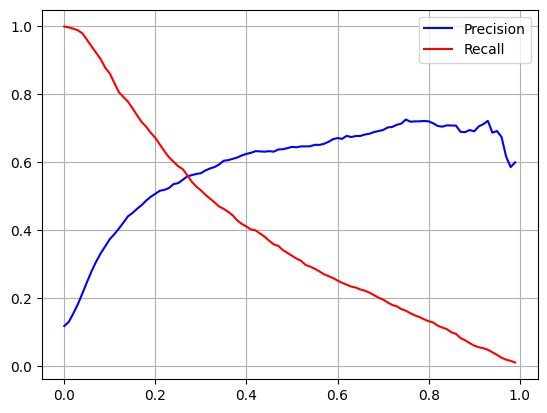

In [98]:
plt.plot(df_scores['threshold'], df_scores['precision'], color='blue', label='Precision')
plt.plot(df_scores['threshold'], df_scores['recall'], color='red', label='Recall')
plt.legend()
plt.grid()
plt.show()

Precision and recall intersect around 0.265

Q4) F1 score

In [99]:
max_f1 = df_scores[df_scores['f1']==df_scores.f1.max()]
max_f1

,threshold,precision,recall,f1
20,0.2,0.507768,0.671963,0.578439


f1 is max around 0.22 

Q5) 5-Fold CV

In [100]:
df_full_train = pd.concat([train, val], ignore_index=True)
y_full_train = df_full_train['y']

In [109]:
from sklearn.model_selection import KFold



def train_model(df_train, y_train, C=1.0):
    dicts = df_train[num_cols+cat_cols].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000, solver='liblinear')
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[num_cols+cat_cols].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = y_full_train[train_idx]
    y_val = y_full_train[val_idx]

    dv, model = train_model(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)





In [113]:
scores_mean = np.mean(scores)
scores_std = np.std(scores)
print(f"Mean AUC Score: {scores_mean}")
print(f"Std deviation of AUC Scores: {scores_std}")

Mean AUC Score: 0.9069252700571834
Std deviation of AUC Scores: 0.005658413265724339


Standard deviation of the scores across different folds - 0.006

Q6) Hyperparameter tuning

In [120]:
C = [0.000001, 0.001, 1]

results = {}
for c in C:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = y_full_train[train_idx]
        y_val = y_full_train[val_idx]

        dv, model = train_model(df_train, y_train, C=c)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    results[f'C={c}'] = [round(np.mean(scores),3),round(np.std(scores),3)]




In [121]:
results

{'C=1e-06': [np.float64(0.706), np.float64(0.009)],
 'C=0.001': [np.float64(0.863), np.float64(0.007)],
 'C=1': [np.float64(0.907), np.float64(0.006)]}

Best mean score is for C=1